In [1]:
from input_feeder import InputFeeder
from mouse_controller import MouseController
import numpy as np
from openvino.inference_engine import IENetwork,IECore
import cv2
from matplotlib import pyplot as plt
import math 

#initialize mouse controller
mouse_controller = MouseController('medium', 'medium')

#initialize models
import face_detection
face_detection_model = 'models/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001'
fd = face_detection.face_detection(face_detection_model,device='GPU')
fd.load_model()
fd.check_model()
fd.get_input_name()


import landmark_detection
landmark_detection_model = 'models/landmarks-regression-retail-0009/FP16/landmarks-regression-retail-0009'
ld = landmark_detection.landmark_detection(landmark_detection_model,device='GPU')
ld.load_model()
ld.check_model()
ld.get_input_name()


import head_pose_estimation
head_pose_estimation_model = 'models/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001'
hd = head_pose_estimation.head_pose_estimation(head_pose_estimation_model,device='GPU')
hd.load_model()
hd.check_model()
hd.get_input_name()

import gaze_estimation
gaze_estimation_model = 'models/gaze-estimation-adas-0002/FP16/gaze-estimation-adas-0002'
ge = gaze_estimation.gaze_estimation(gaze_estimation_model,device='GPU')
ge.load_model()
ge.check_model()
ge.get_input_name()

Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported


In [6]:
# handle image 

from input_feeder import InputFeeder
input_image = 'bin/img6.jpg'

feed = InputFeeder(input_type='image', input_file=input_image)
feed.load_data()
frame = feed.cap


def visualize_frame(frame):
    
    return None

def process_frame(frame):
    #calling face detection

    ##boxes - for visualizing output
    ##face_location - input for other models
    input_img = fd.pre_process_input(frame)
    result = fd.predict(input_img)
    _,boxes = fd.preprocess_output(result)
    face_location = fd.get_face_location()
    
    if (len(boxes) < 1):
        return "No face detected", frame

    # calling landmark detection
    crop_percentage = 0.5
    pre_processed_img = ld.pre_process_input(face_location[0])
    result = ld.predict(pre_processed_img)
    output_image,x_axis,y_axis = ld.preprocess_output(result)
    
    left_eye_crop = ld.crop_left_eye(crop_percentage)
    right_eye_crop = ld.crop_right_eye(crop_percentage)
    
    # Calling head pose estimation
    pre_processed_img = hd.pre_process_input(face_location[0])
    result = hd.predict(pre_processed_img)
    headpose = hd.preprocess_output(result)
    

    # calling gaze model
    res_left = ge.pre_process_input(left_eye_crop)
    res_right = ge.pre_process_input(right_eye_crop)
    result_ge = ge.predict(headpose,res_left,res_right)
    #process_output = ge.preprocess_output(result_ge)
    gaze_vec = result_ge['gaze_vector'][0, :]
    

    rvec = np.array([0, 0, 0], np.float)
    tvec = np.array([0, 0, 0], np.float)
    camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)

    result, _ = cv2.projectPoints(gaze_vec, rvec, tvec, camera_matrix, None)
    result = result[0][0]
    return result,frame
    
#process_frame(frame)

In [13]:
#video input
def process_video(input_video, video_output, stat=None):
    if input_video is None:
        feed = InputFeeder(input_type='cam')
    else:
        feed = InputFeeder(input_type='video', input_file=input_video)

    feed.load_data()

    w = int(feed.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(feed.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(feed.cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_output, fourcc, fps, (w, h), True)

    frame_counter = 0
    for frame in feed.next_batch():
        frame_counter += 1
        result, output_frame = process_frame(frame)
        #out.write(output_frame)

        print("Frame: {} result: {}".format(frame_counter,result))

        if mouse_controller is not None:
            print("Moving mouse: ",result[0], result[1])
            mouse_controller.move(result[0], result[1])

    out.release()
    feed.close()


input_video = 'bin/demo.mp4'
video_output = 'bin/demo_out.mp4'

process_video(input_video, video_output, stat=None)

error: OpenCV(4.3.0-openvino) ../opencv/modules/imgproc/src/resize.cpp:3931: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [15]:
feed.cap.release()

AttributeError: 'numpy.ndarray' object has no attribute 'release'

1 bin/img6.jpg
Identified 2 person
2 bin/img1.png
Identified 5 person
3 bin/img4.jpg
Identified 4 person
1 2
2 5
3 4
1 2
2 5
3 4
Image ID: 1
Image ID: 2
Image ID: 3
Image ID: 1
Face ID 0
Face ID 1


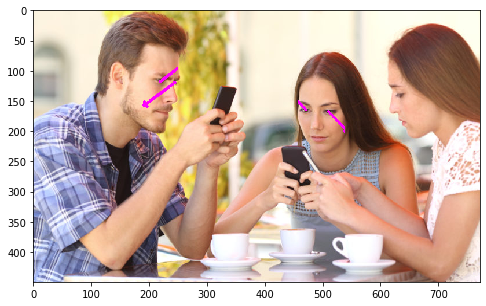

Image ID: 2
Face ID 0
Face ID 1
Face ID 2
Face ID 3
Face ID 4


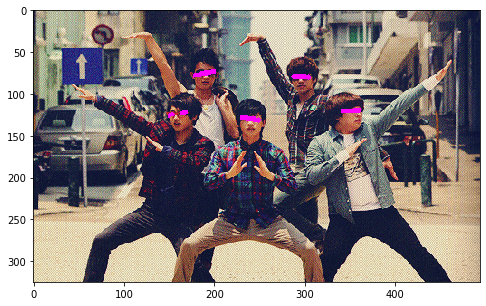

Image ID: 3
Face ID 0
Face ID 1
Face ID 2
Face ID 3


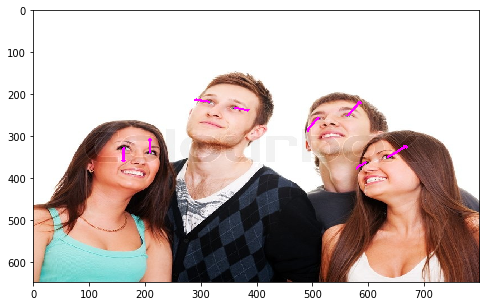

In [22]:
#Handle face detection

input_image = ['bin/img6.jpg','bin/img1.png','bin/img4.jpg']
face_box = [] #for visualizing output
face_location = [] #input for other models


for image_id,input_img in enumerate(input_image):
    
    print(image_id+1,input_img) 
    
    input_img = cv2.imread(input_img)
    input_img = fd.pre_process_input(input_img)
    result = fd.predict(input_img)
    
    output_image,boxes = fd.preprocess_output(result)
    
    face_box.append(boxes)
    
    face_location.append(fd.get_face_location())
    
    print("Identified {} person".format(len(face_location[image_id])))
    
    
# handle landmark detection

crop_percentage = 0.5
left_eye =[]
right_eye = []
x_coord = []
y_coord = []

#cropped_image = ['bin/face-1.jpg','bin/face-2.jpg','bin/face-3.jpg','bin/face-4.jpg','bin/face-5.jpg']
for image_id,faces in enumerate(face_location):
    
    print(image_id+1,len(faces))
    y_coord_tmp = []
    x_coord_tmp = []
    right_eye_tmp = []
    left_eye_tmp = []
    
    for face in faces:
        
        input_img = face
        pre_processed_img = ld.pre_process_input(input_img)
        result = ld.predict(pre_processed_img)
        
        output_image,x_axis,y_axis = ld.preprocess_output(result)
        
        left_eye_crop = ld.crop_left_eye(crop_percentage)
        left_eye_tmp.append(left_eye_crop)
        right_eye_crop = ld.crop_right_eye(crop_percentage)
        right_eye_tmp.append(right_eye_crop)
        
        y_coord_tmp.append(y_axis)
        x_coord_tmp.append(x_axis)
    
    y_coord.append(y_coord_tmp)
    x_coord.append(x_coord_tmp)
    left_eye.append(left_eye_tmp)
    right_eye.append(right_eye_tmp)
    
#Handle head pose

headpose=[]

for image_id,faces in enumerate(face_location):
    
    print(image_id+1,len(faces))
    headpose_temp=[]

    for face in faces:
        pre_processed_img = hd.pre_process_input(face)
        result = hd.predict(pre_processed_img)
        output = hd.preprocess_output(result)
        headpose_temp.append(output)
    headpose.append(headpose_temp)
    
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]
result_gaze_model = []


for image_id,faces in enumerate(face_location):
    
    print("Image ID:",image_id+1)
    ge_results_tmp = []
    result_ge_tmp = []

    for face_id,face in enumerate(faces):
        res_left = ge.pre_process_input(left_eye[image_id][face_id])
        res_right = ge.pre_process_input(right_eye[image_id][face_id])
              
        result_ge = ge.predict(headpose[image_id][face_id],res_left,res_right)
        process_output = ge.preprocess_output(result_ge)
        ge_results_tmp.append(process_output)
        
        gaze_vec = result_ge['gaze_vector'].tolist()[0]
        result_ge_tmp.append(gaze_vec)
     
    ge_results.append(ge_results_tmp)
    result_gaze_model.append(result_ge_tmp)

for image_id,faces in enumerate(face_location):
    
    print("Image ID:",image_id+1)
    image1 = cv2.imread(input_image[image_id])

    for face_id,face in enumerate(faces):
        print("Face ID",face_id)
        image_copy = face
        cv2.arrowedLine(image_copy, (x_coord[image_id][face_id][0],y_coord[image_id][face_id][0]),
                                (x_coord[image_id][face_id][0] + int(result_gaze_model[image_id][face_id][0]*100),
                                 y_coord[image_id][face_id][0]+int(result_gaze_model[image_id][face_id][1]*100)),
                                (255,0,255),3)
        
        cv2.arrowedLine(image_copy, 
                        (x_coord[image_id][face_id][1],y_coord[image_id][face_id][1]), 
                        (x_coord[image_id][face_id][1] - int(result_gaze_model[image_id][face_id][0]*100), 
                         y_coord[image_id][face_id][1] - int(result_gaze_model[image_id][face_id][1]*100)),
                        (255,0,255),3)
        image1[face_box[image_id][face_id][1]:face_box[image_id][face_id][3], face_box[image_id][face_id][0]:face_box[image_id][face_id][2]] = image_copy

                      
    ld.plot_image(image1)

In [13]:
#Handle face detection

input_image = ['bin/img6.jpg','bin/img1.png','bin/img4.jpg']
face_box = [] #for visualizing output
face_location = [] #input for other models


for image_id,input_img in enumerate(input_image):
    
    print(image_id+1,input_img) 
    
    input_img = cv2.imread(input_img)
    input_img = fd.pre_process_input(input_img)
    result = fd.predict(input_img)
    
    output_image,boxes = fd.preprocess_output(result)
    
    face_box.append(boxes)
    
    face_location.append(fd.get_face_location())
    
    print("Identified {} person".format(len(face_location[image_id])))
    
    

1 bin/img6.jpg
Identified 2 person
2 bin/img1.png
Identified 5 person
3 bin/img4.jpg
Identified 4 person


1 bin/img6.jpg


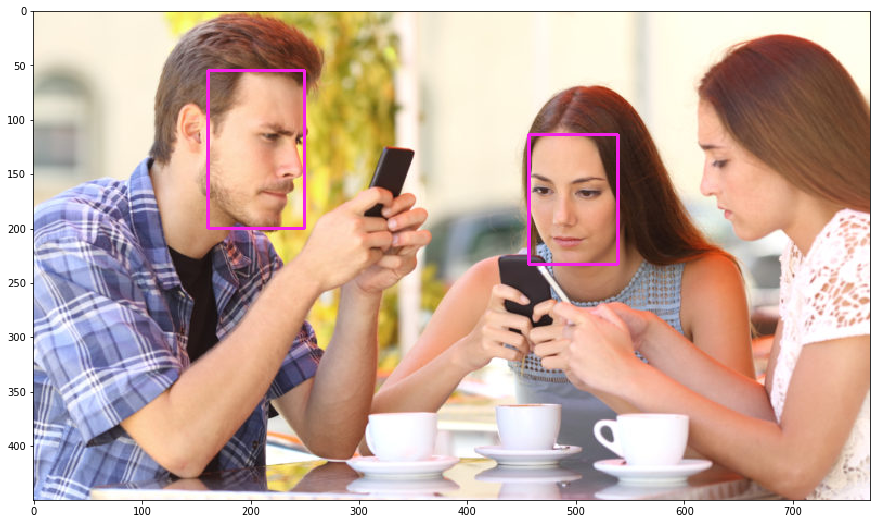

2 bin/img1.png


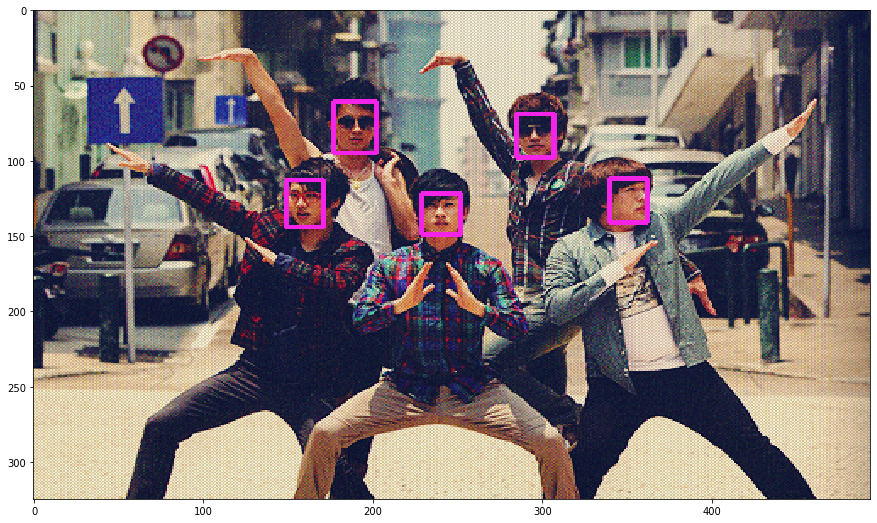

3 bin/img4.jpg


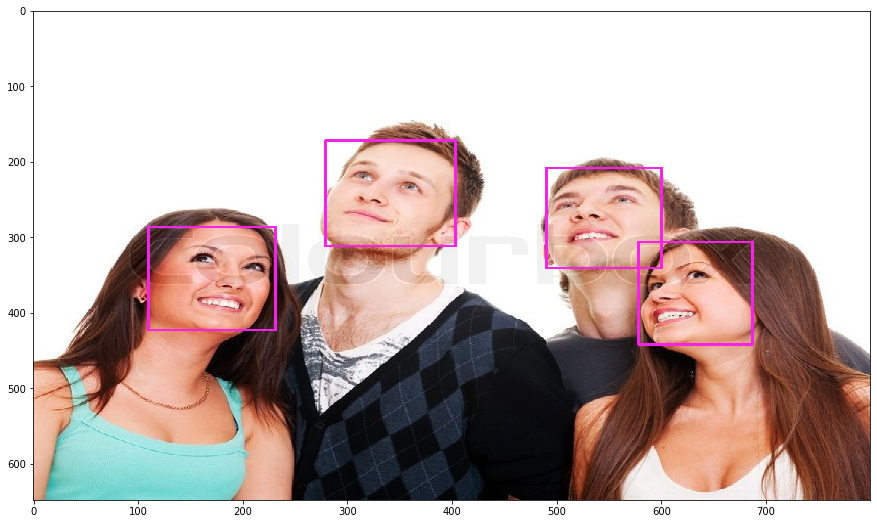

In [14]:
#Visualizing output

for image_id,faces in enumerate(face_box):
    temp_image = cv2.imread(input_image[image_id])
    print(image_id+1,input_image[image_id])

    for face_id,box in enumerate(faces):
        #print(face_id,box,image_id)
        cv2.rectangle(temp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)

    fd.plot_image(temp_image)

In [15]:
# handle landmark detection

crop_percentage = 0.5
left_eye =[]
right_eye = []
x_coord = []
y_coord = []

#cropped_image = ['bin/face-1.jpg','bin/face-2.jpg','bin/face-3.jpg','bin/face-4.jpg','bin/face-5.jpg']
for image_id,faces in enumerate(face_location):
    
    print(image_id+1,len(faces))
    y_coord_tmp = []
    x_coord_tmp = []
    right_eye_tmp = []
    left_eye_tmp = []
    
    for face in faces:
        
        input_img = face
        pre_processed_img = ld.pre_process_input(input_img)
        result = ld.predict(pre_processed_img)
        
        output_image,x_axis,y_axis = ld.preprocess_output(result)
        
        left_eye_crop = ld.crop_left_eye(crop_percentage)
        left_eye_tmp.append(left_eye_crop)
        right_eye_crop = ld.crop_right_eye(crop_percentage)
        right_eye_tmp.append(right_eye_crop)
        
        y_coord_tmp.append(y_axis)
        x_coord_tmp.append(x_axis)
    
    y_coord.append(y_coord_tmp)
    x_coord.append(x_coord_tmp)
    left_eye.append(left_eye_tmp)
    right_eye.append(right_eye_tmp)


1 2
2 5
3 4


Image ID 1
Face ID:  1
Face ID:  2


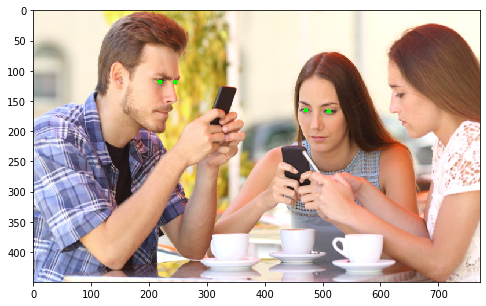

Image ID 2
Face ID:  1
Face ID:  2
Face ID:  3
Face ID:  4
Face ID:  5


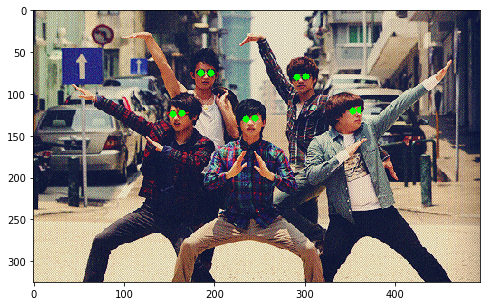

Image ID 3
Face ID:  1
Face ID:  2
Face ID:  3
Face ID:  4


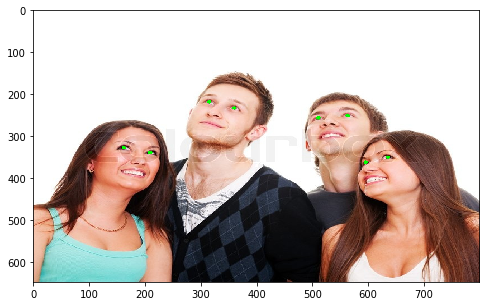

In [16]:
#Visualizing output
face_location_copy = face_location.copy()

for image_id,faces in enumerate(face_location_copy):
    
    print("Image ID",image_id+1)
    image = cv2.imread(input_image[image_id])
    
    for face_id,face in enumerate(faces):
        print("Face ID: ",face_id+1)
        
        for x,y in zip(x_coord[image_id][face_id][:2],y_coord[image_id][face_id][:2]):
            cv2.circle(face,(x, y), 1, (0,255,0), 5)
            image[face_box[image_id][face_id][1]:face_box[image_id][face_id][3], face_box[image_id][face_id][0]:face_box[image_id][face_id][2]] =face

    ld.plot_image(image)


In [17]:
#Handle head pose

headpose=[]

for image_id,faces in enumerate(face_location):
    
    print(image_id+1,len(faces))
    headpose_temp=[]

    for face in faces:
        pre_processed_img = hd.pre_process_input(face)
        result = hd.predict(pre_processed_img)
        output = hd.preprocess_output(result)
        headpose_temp.append(output)
    headpose.append(headpose_temp)
    
headpose

1 2
2 5
3 4


[[array([[-22.11076  ,  13.630291 ,   1.7855039]], dtype=float32),
  array([[56.976883,  5.180355,  5.987177]], dtype=float32)],
 [array([[ 3.488738  , -6.219278  ,  0.64340997]], dtype=float32),
  array([[ 50.11553 , -11.118887,   6.5541  ]], dtype=float32),
  array([[-3.8079789,  2.8880997,  1.348587 ]], dtype=float32),
  array([[  6.665414, -14.302602,  -3.134253]], dtype=float32),
  array([[-2.461281 , -7.9560323, -2.4275198]], dtype=float32)],
 [array([[ 17.51461 , -16.911953,  12.636393]], dtype=float32),
  array([[-11.527042 , -30.622404 ,  -1.2856951]], dtype=float32),
  array([[-26.798012, -30.110744, -10.587401]], dtype=float32),
  array([[-11.921646, -21.784552,  13.926434]], dtype=float32)]]

In [18]:
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]
result_gaze_model = []


for image_id,faces in enumerate(face_location):
    
    print("Image ID:",image_id+1)
    ge_results_tmp = []
    result_ge_tmp = []

    for face_id,face in enumerate(faces):
        res_left = ge.pre_process_input(left_eye[image_id][face_id])
        res_right = ge.pre_process_input(right_eye[image_id][face_id])
              
        result_ge = ge.predict(headpose[image_id][face_id],res_left,res_right)
        process_output = ge.preprocess_output(result_ge)
        ge_results_tmp.append(process_output)
        
        gaze_vec = result_ge['gaze_vector'].tolist()[0]
        result_ge_tmp.append(gaze_vec)
     
    ge_results.append(ge_results_tmp)
    result_gaze_model.append(result_ge_tmp)

result_gaze_model

Image ID: 1
Image ID: 2
Image ID: 3


[[[-0.1255197525024414, -0.3070310354232788, -0.9296920299530029],
  [0.6360508799552917, -0.3402133584022522, -0.7009539008140564]],
 [[0.059660546481609344, -0.11498977988958359, -0.9244214296340942],
  [0.5335719585418701, -0.11776622384786606, -0.8344025611877441],
  [-0.0657903328537941, -0.1490933895111084, -0.916979968547821],
  [0.14355190098285675, -0.07253029197454453, -0.9185308218002319],
  [0.0067816078662872314, -0.019478119909763336, -0.8943626880645752]],
 [[0.40175482630729675, 0.2778940200805664, -0.7974050045013428],
  [-0.1908048540353775, 0.27239030599594116, -0.9254946112632751],
  [-0.26101353764533997, 0.4107557535171509, -0.8334043622016907],
  [-0.06758531183004379, 0.033490750938653946, -0.956200361251831]]]

Image ID: 1
Face ID 0
Face ID 1


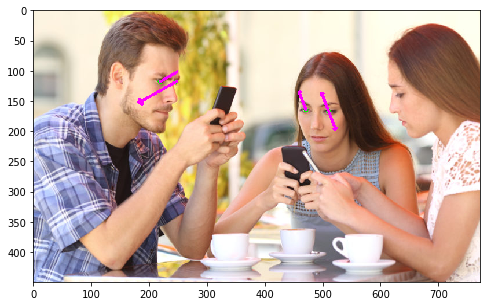

Image ID: 2
Face ID 0
Face ID 1
Face ID 2
Face ID 3
Face ID 4


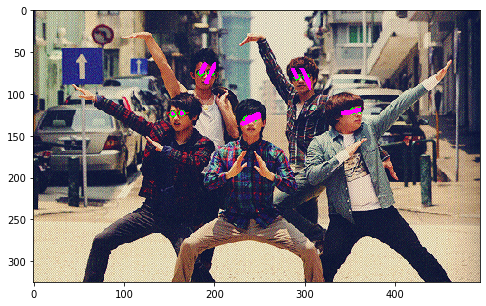

Image ID: 3
Face ID 0
Face ID 1
Face ID 2
Face ID 3


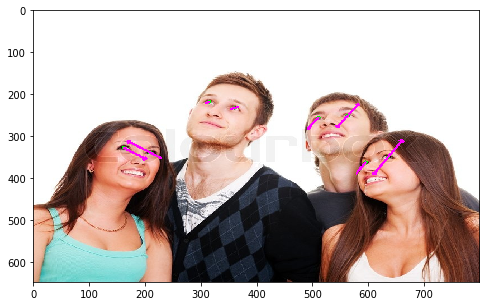

In [20]:
#visualize gaze model


for image_id,faces in enumerate(face_location):
    
    print("Image ID:",image_id+1)
    image1 = cv2.imread(input_image[image_id])

    for face_id,face in enumerate(faces):
        print("Face ID",face_id)
        image_copy = face
        cv2.arrowedLine(image_copy, (x_coord[image_id][face_id][0],y_coord[image_id][face_id][0]),
                                (x_coord[image_id][face_id][0] + int(result_gaze_model[image_id][face_id][0]*100),
                                 y_coord[image_id][face_id][0]+int(result_gaze_model[image_id][face_id][1]*100)),
                                (255,0,255),3)
        
        cv2.arrowedLine(image_copy, 
                        (x_coord[image_id][face_id][1],y_coord[image_id][face_id][1]), 
                        (x_coord[image_id][face_id][1] - int(result_gaze_model[image_id][face_id][0]*100), 
                         y_coord[image_id][face_id][1] - int(result_gaze_model[image_id][face_id][1]*100)),
                        (255,0,255),3)
        image1[face_box[image_id][face_id][1]:face_box[image_id][face_id][3], face_box[image_id][face_id][0]:face_box[image_id][face_id][2]] = image_copy

                      
    ld.plot_image(image1)

In [ ]:
#idx=0
gaze_vector = []
for idx in range(len(left_eye_input)):
    result_ge = ge.predict(headpose[idx],left_eye_input[idx],right_eye_input[idx])
    print(idx,result_ge)
    gaze_vec = result_ge['gaze_vector'].tolist()[0]
    gaze_vector.append(gaze_vec)
    image_copy = cropped_image[idx]
    image = cv2.arrowedLine(image_copy, (x_coord[idx][0],y_coord[idx][0]),
                            (x_coord[idx][0] + int(gaze_vector[idx][0]*100),
                             y_coord[idx][0]+int(gaze_vector[idx][1]*100)),
                            (255,0,255),3)
    image = cv2.arrowedLine(image_copy, 
                    (x_coord[idx][1],y_coord[idx][1]), 
                    (x_coord[idx][1] - int(gaze_vector[idx][0]*100), 
                     y_coord[idx][1]-int(gaze_vector[idx][1]*100)),
                    (255,0,255),3)
    ld.plot_image(image)

In [ ]:
a,b =[],[]
for image_id in range(2):
    print(image_id)
    for face in range(3):
        input_img = face
        pre_processed_img = ld.pre_process_input(input_img)
        result = ld.predict(pre_processed_img)
        output_image,x_axis,y_axis = ld.preprocess_output(result)
        left_eye_crop = ld.crop_left_eye(crop_percentage)
        left_eye.append(left_eye_crop)
        right_eye_crop = ld.crop_right_eye(crop_percentage)
        right_eye.append(right_eye_crop)
        y_coord.append(y_axis)
        x_coord.append(x_axis)

In [10]:
#Visualizing output
input_image = ['bin/img1.png']
for image_id in range(len(input_image)):
    temp_image = cv2.imread(input_image[image_id])
    print(image_id+1,input_image[image_id])
    for x,y in zip(x_coord, y_coord):
        print(x,y)
        #temp_image = cv2.circle(temp_image,(x[0], y[0]), 1, (0,255,0), 1)
        #temp_image = cv2.circle(temp_image,(x[1], y[1]), 1, (0,255,0), 1)
     

    #ld.plot_image(temp_image)

5

In [25]:
#finding size of cropped image

fd.plot_image(face_location[[0][0]])


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [43]:
face_box[0][0]


[177, 61, 202, 95]

In [47]:
b = input_image[0]
b = cv2.imread(b)
c = b[face_box[0][0][1]:face_box[0][0][3], face_box[0][0][0]:face_box[0][0][2]]

#fd.plot_image(b)

In [70]:
len(face_box[image_id])-1

4

0 bin/img1.png
Face ID:  1
[177, 61, 202, 95]
Face ID:  2
[340, 112, 362, 141]
Face ID:  3
[285, 69, 307, 98]
Face ID:  4
[229, 122, 252, 149]
Face ID:  5
[149, 113, 171, 144]


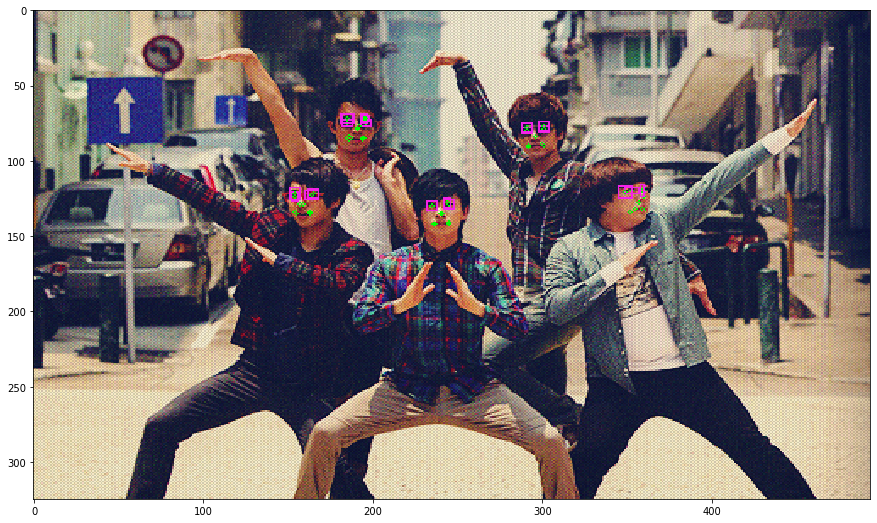

1 bin/img4.jpg
Face ID:  1
[110, 286, 231, 423]
Face ID:  2
[490, 208, 600, 341]
Face ID:  3
[578, 306, 687, 442]
Face ID:  4
[279, 172, 403, 312]


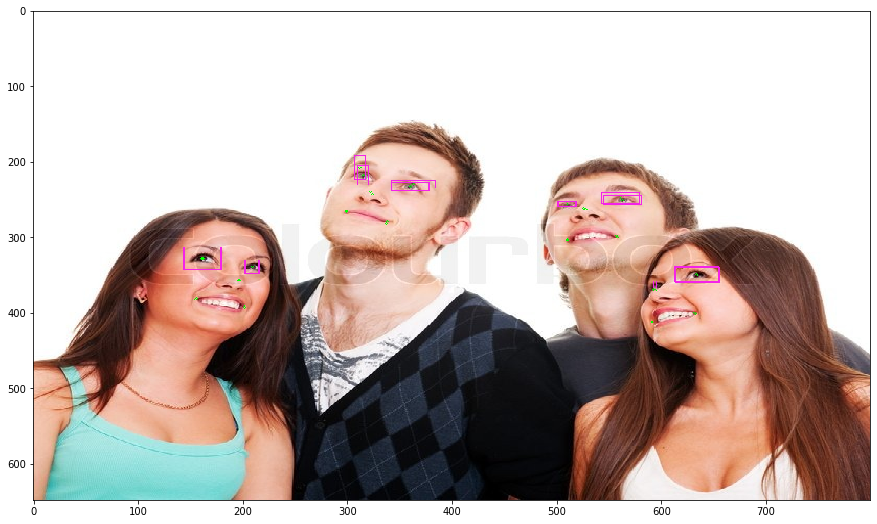

In [75]:
for image_id, image in enumerate(input_image):
    print(image_id, image)
    org_img = cv2.imread(image)
    
    for face_id in range(len(face_box[image_id])):
        print("Face ID: ", face_id+1)
        print(face_box[image_id][face_id])

        cropped_img_to_replace = cropped_image[image_id][face_id]
        org_img[face_box[image_id][face_id][1]:face_box[image_id][face_id][3], face_box[image_id][face_id][0]:face_box[image_id][face_id][2]] = cropped_img_to_replace
        
        
    fd.plot_image(org_img)
    

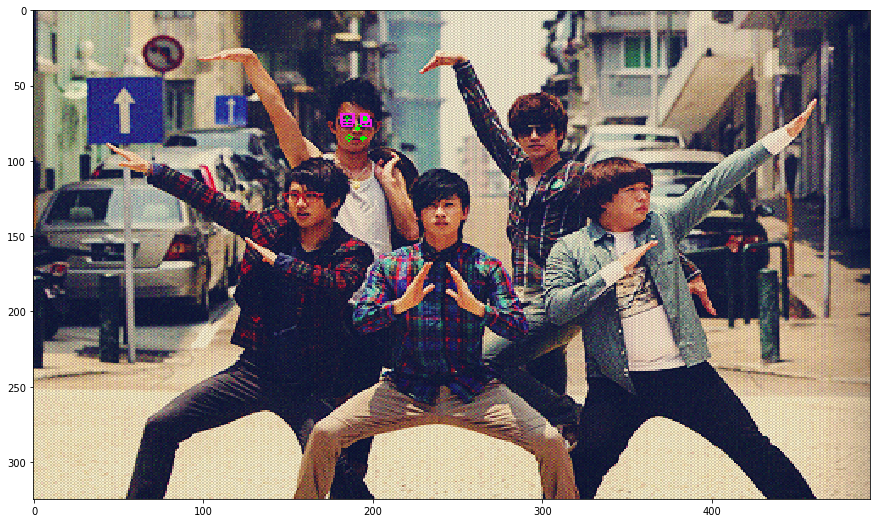

In [48]:
b[face_box[0][0][1]:face_box[0][0][3], face_box[0][0][0]:face_box[0][0][2]] = a
fd.plot_image(b) 

In [44]:
#Handle head pose

headpose=[]
for image_id,input_img in enumerate(cropped_image):
    pre_processed_img = hd.pre_process_input(input_img)
    result = hd.predict(pre_processed_img)
    output = hd.preprocess_output(result)
    headpose.append(output)
    
headpose

[array([[ 16.989155, -16.42661 ,   9.898043]], dtype=float32),
 array([[-12.601593 , -33.601944 ,  -2.3125439]], dtype=float32),
 array([[-25.263527, -28.041058,  -9.827201]], dtype=float32),
 array([[-11.9453125, -18.220198 ,  14.118452 ]], dtype=float32)]

In [45]:
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]

for value in left_eye:
    res = ge.pre_process_input(value)
    left_eye_input.append(res)
    
for value in right_eye:
    res = ge.pre_process_input(value)
    right_eye_input.append(res)


for idx in range(len(left_eye_input)):
    result_ge = ge.predict(headpose[idx],left_eye_input[idx],right_eye_input[idx])
    process_output = ge.preprocess_output(result_ge)
    ge_results.append(process_output)
    
ge_results

[array([[-0.03486424,  0.32357246, -0.8987567 ]], dtype=float32),
 array([[-0.20174135,  0.35231668, -0.89900166]], dtype=float32),
 array([[-0.32831433,  0.41646254, -0.78113896]], dtype=float32),
 array([[-0.26417422,  0.02325774, -0.9431226 ]], dtype=float32)]

In [46]:
#testing single image
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]

for value in left_eye:
    res = ge.pre_process_input(value)
    left_eye_input.append(res)
    
for value in right_eye:
    res = ge.pre_process_input(value)
    right_eye_input.append(res)



0 {'gaze_vector': array([[-0.03486424,  0.32357246, -0.8987567 ]], dtype=float32)}


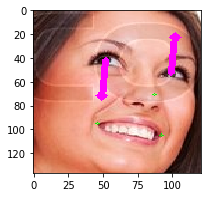

1 {'gaze_vector': array([[-0.20174135,  0.35231668, -0.89900166]], dtype=float32)}


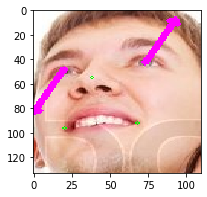

2 {'gaze_vector': array([[-0.32831433,  0.41646254, -0.78113896]], dtype=float32)}


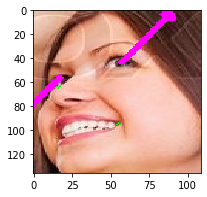

3 {'gaze_vector': array([[-0.26417422,  0.02325774, -0.9431226 ]], dtype=float32)}


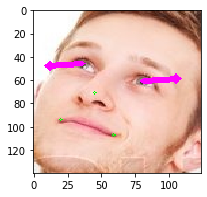

In [47]:
#idx=0
gaze_vector = []
for idx in range(len(left_eye_input)):
    result_ge = ge.predict(headpose[idx],left_eye_input[idx],right_eye_input[idx])
    print(idx,result_ge)
    gaze_vec = result_ge['gaze_vector'].tolist()[0]
    gaze_vector.append(gaze_vec)
    image_copy = cropped_image[idx]
    image = cv2.arrowedLine(image_copy, (x_coord[idx][0],y_coord[idx][0]),
                            (x_coord[idx][0] + int(gaze_vector[idx][0]*100),
                             y_coord[idx][0]+int(gaze_vector[idx][1]*100)),
                            (255,0,255),3)
    image = cv2.arrowedLine(image_copy, 
                    (x_coord[idx][1],y_coord[idx][1]), 
                    (x_coord[idx][1] - int(gaze_vector[idx][0]*100), 
                     y_coord[idx][1]-int(gaze_vector[idx][1]*100)),
                    (255,0,255),3)
    ld.plot_image(image)
    

In [39]:
#gaze vector processing output


gaze_vector = result_ge['gaze_vector'].tolist()[0]
rollValue = headpose[idx][0][2]

cosValue = math.cos(rollValue * math.pi / 180.0)
sinValue = math.sin(rollValue * math.pi / 180.0)

newx = gaze_vector[0] * cosValue + gaze_vector[1] * sinValue
newy = -gaze_vector[0] *  sinValue+ gaze_vector[1] * cosValue


(newx,newy), gaze_vector

((0.11908751383054772, 0.43520515941588417),
 [0.08088379353284836, 0.44389545917510986, -0.7408611178398132])

In [42]:
x_coord,y_coord

([53, 82, 78, 52, 76], [54, 54, 76, 104, 104])

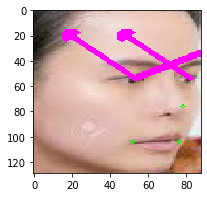

In [49]:
eye_id = 0
image = cv2.arrowedLine(cropped_image[idx], 
                        (x_coord[eye_id],y_coord[eye_id]), 
                        (x_coord[eye_id] + int(gaze_vector[0]*100), 
                         y_coord[eye_id]+int(gaze_vector[1]*100)),
                        (255,0,255),3) 
ld.plot_image(image)

In [48]:

x_coord[eye_id] + int(gaze_vector[0]*100), y_coord[eye_id]+int(gaze_vector[1]*100)

(115, 18)

In [ ]:
x_coord[1] - int(gaze_vector[1]*100), y_coord[2]+int(gaze_vector[1]*100)

In [56]:
gaze_vector[0][1]*100

-36.82376444339752

In [ ]:
x, y, w = int(gaze_vector[0]*12), int(gaze_vector[1]*12), 160
le =cv2.line(left_eye.copy(), (x-w, y-w), (x+w, y+w), (255,0,255), 2)
cv2.line(le, (x-w, y+w), (x+w, y-w), (255,0,255), 2)
re = cv2.line(right_eye.copy(), (x-w, y-w), (x+w, y+w), (255,0,255), 2)
cv2.line(re, (x-w, y+w), (x+w, y-w), (255,0,255), 2)
croppedFace[eye_coords[0][1]:eye_coords[0][3],eye_coords[0][0]:eye_coords[0][2]] = le
croppedFace[eye_coords[1][1]:eye_coords[1][3],eye_coords[1][0]:eye_coords[1][2]] = re


In [6]:
rvec = np.array([0, 0, 0], np.float)
# translation vector
tvec = np.array([0, 0, 0], np.float)
# camera matrix
camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)

result, _ = cv2.projectPoints((0.27571675,  0.17352335, -0.65603495), rvec, tvec, camera_matrix, None)
result

array([[[-0.42027753, -0.26450321]]])

In [7]:
cv2.projectPoints((0.27571675,  0.17352335, -0.65603495), rvec, tvec, camera_matrix, None)


(array([[[-0.42027753, -0.26450321]]]),
 array([[-0.11116476,  1.1766332 ,  0.26450321, -1.52430903,  0.        ,
         -0.64063284, -0.42027753,  0.        ,  1.        ,  0.        ,
         -0.1036384 , -0.02555673,  0.22232951,  0.59986156, -0.00630217],
        [-1.06996195,  0.11116476, -0.42027753,  0.        , -1.52430903,
         -0.40318463,  0.        , -0.26450321,  0.        ,  1.        ,
         -0.06522521, -0.01608422,  0.38651905,  0.22232951, -0.00396629]]))

In [12]:
result = result[0,0]
cropped_image[0]
left_eye =[]
right_eye = []

In [14]:
left_eye[0][0][0]

array([60, 31, 35], dtype=uint8)

In [ ]:
res = (int(result[0] * 100), int(result[1] * 100))  #2.5, 2.9
e1 = (cropped_image[0][0][0] + model_landmarks_output[0][0],
      cropped_image[0][0][1] + model_landmarks_output[0][1])
e2 = (cropped_image[0][0][0] + model_landmarks_output[1][0],
      cropped_image[0][0][1] + model_landmarks_output[1][1])

cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)

In [ ]:
def display_intermediate(image, model_face_output, model_landmarks_output, result):
    # face bounding box
    image = cv2.rectangle(image, model_face_output[0], model_face_output[1], (255, 0, 0), 2)

    # gaze vector projection
    res = (int(result[0] * 100), int(result[1] * 100))
    e1 = (model_face_output[0][0] + model_landmarks_output[0][0],
          model_face_output[0][1] + model_landmarks_output[0][1])
    e2 = (model_face_output[0][0] + model_landmarks_output[1][0],
          model_face_output[0][1] + model_landmarks_output[1][1])

    cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
    cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)
    return image

In [ ]:
def process_single_frame(image, display_intermediate_output):
    model_face_output = model_face.predict(image)
    if model_face_output[2] is None:
        return 'No face detected', image

    model_landmarks_output = model_landmarks.predict(model_face_output[2])
    model_head_pose_output = model_hpose.predict(model_face_output[2])
    gaze_estimation_output = model_gaze_estimation.predict(
        ((model_landmarks_output[2], model_landmarks_output[3]), model_head_pose_output))

    # rotation vector
    rvec = np.array([0, 0, 0], np.float)
    # translation vector
    tvec = np.array([0, 0, 0], np.float)
    # camera matrix
    camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)

    result, _ = cv2.projectPoints(gaze_estimation_output, rvec, tvec, camera_matrix, None)
    result = result[0][0]

    if display_intermediate_output:
        image = display_intermediate(image, model_face_output, model_landmarks_output, result)

    print('.', end='', flush=True)
    return result, image



def display_intermediate(image, model_face_output, model_landmarks_output, result):
    # face bounding box
    image = cv2.rectangle(image, model_face_output[0], model_face_output[1], (255, 0, 0), 2)

    # gaze vector projection
    res = (int(result[0] * 100), int(result[1] * 100))
    e1 = (model_face_output[0][0] + model_landmarks_output[0][0],
          model_face_output[0][1] + model_landmarks_output[0][1])
    e2 = (model_face_output[0][0] + model_landmarks_output[1][0],
          model_face_output[0][1] + model_landmarks_output[1][1])

    cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
    cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)
    return image